# Example: Controllability Analysis (Part 2)

- Author: Parker Smith
- Date: 12/29/2025

## Introduction

In the previous part, we evaluated some of the basic capabilities of `DyMAD` in regard to controllability. Now, we will look at an example where the encoding/decoding between latent and physical space is non-trivial; this will better showcase the capabilities of the code and verify its use in complex problems (e.g. when the real state is not fully observable).

## Problem

This example explores a **controlled nonlinear dynamical system** with two state variables $x = [x_1, x_2]$. The system dynamics are given by:

$$
\begin{aligned}
\dot{x}_1 &= \mu x_1 \\
\dot{x}_2 &= \lambda (x_2 - x_1^2)
\end{aligned}
$$

where the parameters are $\mu = -0.5$ and $\lambda = -3$.

We begin with some imports:

In [5]:
# Import packages:
import matplotlib.pyplot as plt
import numpy as np
import torch
from dymad.io import load_model
from dymad.models import KBF
from dymad.training import NODETrainer, WeakFormTrainer
from dymad.utils import plot_summary, plot_trajectory, TrajectorySampler
from funcs import *

Next, we will set up our trainer:

In [6]:
# Parameters:
B = 300
N = 301
t_grid = np.linspace(0, 6, N)
mu = -0.5
lm = -3

# Helper function:
def f(t, x):
    _d = np.array([mu*x[0], lm*(x[1]-x[0]**2)])
    return _d

# Options for KBF, generic autoencoder, and weak form
mdl_kb = {
    "encoder_layers" : 2,
    "decoder_layers" : 2,
    "hidden_dimension" : 32,
    "koopman_dimension" : 4,
    "activation" : "prelu",
    "weight_init" : "xavier_uniform"}
crit = {
        "dynamics" : {"weight" : 1.0},
        "recon" : {"weight" : 1.0}}
trn_wf = {
    "n_epochs": 1000,
    "save_interval": 50,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "weak_form_params": {
        "N": 13,
        "dN": 2,
        "ordpol": 2,
        "ordint": 2}}

config_path = 'kp_model.yaml'
mdl_cat = {
    "name" : "kp_cat",
    "autoencoder_type" : "cat"}
mdl_cat.update(**mdl_kb)

Then, sample trajectories for training:

In [7]:
# Sample trajectories:
sampler = TrajectorySampler(f, config='kp_data.yaml')
ts, xs, ys = sampler.sample(t_grid, batch=B, save='./data/kp.npz')

#And then train the model:

In [8]:
trainer = WeakFormTrainer(config_path, KBF, config_mod={"model":mdl_cat, "criterion":crit, "training":trn_wf})
trainer.train();

Now we will generate a test trajectory to help verify the trainer has converged:

array([<Axes: ylabel='State 1'>, <Axes: xlabel='Time', ylabel='State 2'>],
      dtype=object)

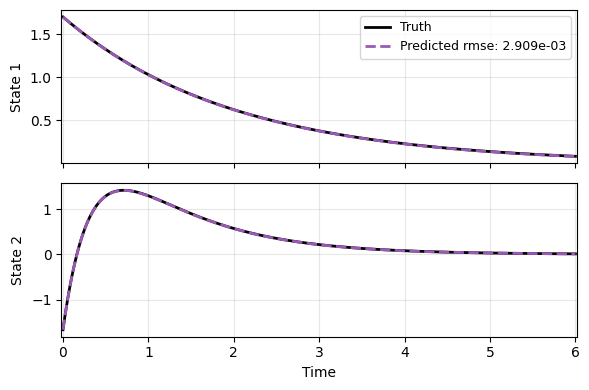

In [9]:
# Sample a trajectory:
sampler = TrajectorySampler(f, config='kp_data.yaml')
ts, xs, ys = sampler.sample(t_grid, batch=1)
x_data = xs[0]
t_data = ts[0]

# The variation
model, prd_func = load_model(KBF, f'kp_cat.pt')
with torch.no_grad():
    pred_cat = prd_func(x_data, t_data)
res = [x_data, pred_cat]

# Plot comparison:
labels = ['Truth', 'Predicted']
plot_trajectory(np.array(res), t_data, "KP", labels=labels, ifclose=False)

Next, we can fetch the linearization matrices as before:

In [10]:
# Get system matrices linearized around equilibrium (trim) condition:
x_ref = np.array([0, 0])
A, _, C = linearize(model, x_ref)

# Discretize:
dt = t_grid[1] - t_grid[0]
A, _ = discretize_system(A[0], np.zeros((A.shape[0], 1)), dt)
# Grab the first matrices for C:
C = C[0]

To test these matrices, we can propagate a nominal trajectory to see if it matches our expectations above:

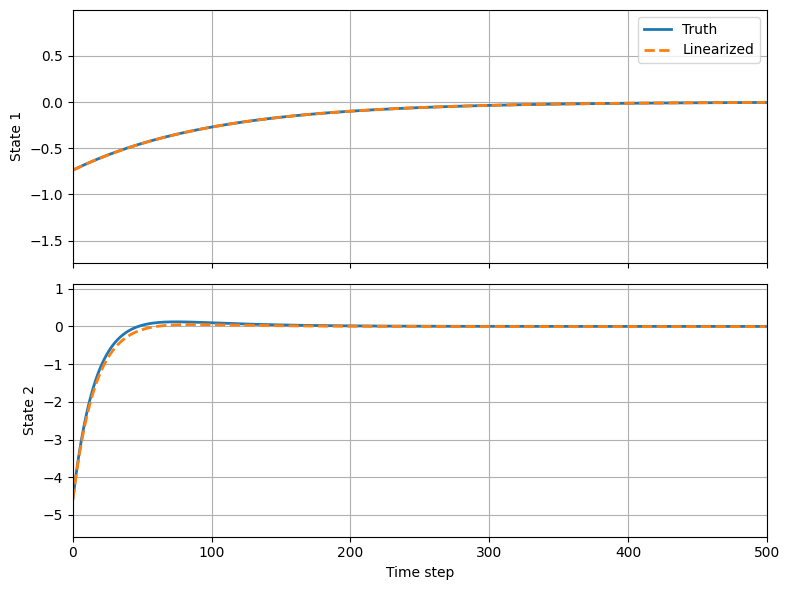

In [11]:
# Sample one random trajectory:
N = 500
t_grid = np.linspace(0, 10, N)
ts, xs, ys = sampler.sample(t_grid, batch=1)

# Extract data:
x_true = xs[0]
t_data = ts[0]
x0 = x_true[0]
n_tsteps = len(x_true) - 1

# Linearized prediction:
x_linear, _ = prop_dyn_latent(model, A, None, C, x0, n_tsteps=n_tsteps)

# Plot comparison:
plot_traj(np.stack([x_true.T, x_linear.T], axis=-1), None, N, lab=["Truth", "Linearized"], line=["-", "--"])

which shows how we are able to track the complex trajectory with a surprising amount of accuracy using the linearized matrices in the latent space.

## Problem

This example further explores a **controlled nonlinear dynamical system** with two state variables $x = [x_1, x_2]$ by adding a nominal control capability. The system dynamics are given by:

$$
\begin{aligned}
\dot{x}_1 &= \mu x_1 + u_1 \\
\dot{x}_2 &= \lambda (x_2 - x_1^2) + u_2
\end{aligned}
$$

where the parameters are $\mu = -0.5$ and $\lambda = -3$, and now $u = [u_1, u_2]$ represents the control inputs applied to each state variable.

First, setup trainer:

In [12]:
# Parameters:
B = 300
N = 301
t_grid = np.linspace(0, 6, N)
mu = -0.5
lm = -3

# Helper function:
def f(t, x, u):
    x1, x2 = x[0], x[1]

    dx1 = mu * x1 + u[0]
    dx2 = lm * (x2 - x1**2)

    return np.array([dx1, dx2])

# Options for KBF, generic autoencoder, and weak form
mdl_kb = {
    "encoder_layers" : 2,
    "decoder_layers" : 2,
    "hidden_dimension" : 32,
    "koopman_dimension" : 4,
    "activation" : "prelu",
    "weight_init" : "xavier_uniform"}
crit = {
        "dynamics" : {"weight" : 1.0},
        "recon" : {"weight" : 1.0}}
trn_wf = {
    "n_epochs": 1000,
    "save_interval": 50,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "weak_form_params": {
        "N": 13,
        "dN": 2,
        "ordpol": 2,
        "ordint": 2}}

config_path = 'kp_model_ctrl.yaml'
mdl_cat = {
    "name" : "kp_ctrl",
    "autoencoder_type" : "cat"}
mdl_cat.update(**mdl_kb)

Next, generate some sample trajectories for training:

In [13]:
# Sample trajectories:
sampler = TrajectorySampler(f, config='kp_data_ctrl.yaml')
ts, xs, us, ys = sampler.sample(t_grid, batch=B, save='./data/kp_ctrl.npz')

And train the model:

In [14]:
trainer = WeakFormTrainer(config_path, KBF, config_mod={"model":mdl_cat, "criterion":crit, "training":trn_wf})
trainer.train();

And verify the training by plotting the predicted model against the truth:

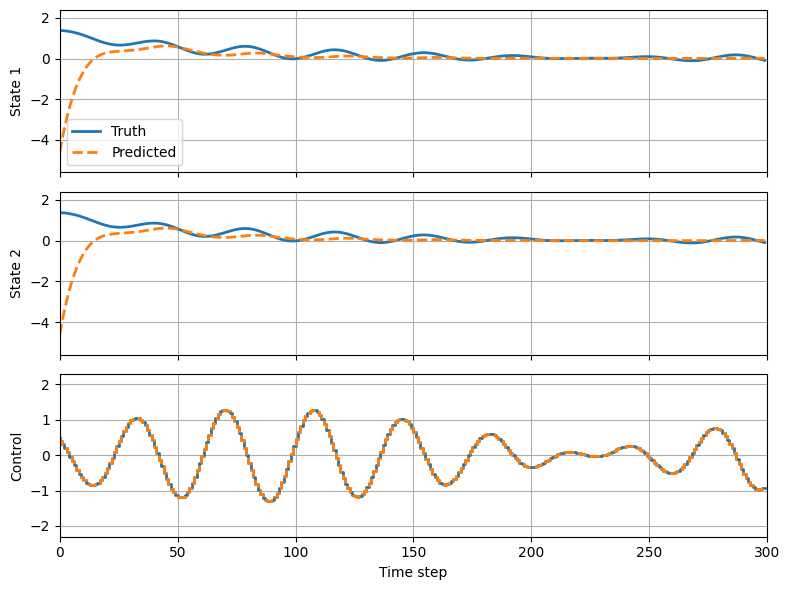

In [24]:
# Sample a trajectory:
sampler = TrajectorySampler(f, config='kp_data_ctrl.yaml')
ts, xs, us, ys = sampler.sample(t_grid, batch=1)
x_data = xs[0]
t_data = ts[0]
u_data = us[0]

# The variation
model, prd_func = load_model(KBF, f'kp_ctrl.pt')
with torch.no_grad():
    pred_cat = prd_func(x_data, t_data, u=u_data)
res = [x_data, pred_cat]

# Plot comparison:
plot_traj(np.array(res), u_data, N, lab=["Truth", "Predicted"], line=["-", "--"])

And similarly, linearize the matrices:

In [25]:
# Load model:
model, prd_func = load_model(KBF, f'kp_ctrl.pt')

# Get system matrices linearized around equilibrium (trim) condition:
x_ref = np.array([0, 0])
u_ref = np.array([0])
A, B, C = linearize(model, x_ref, u_ref)

# Discretize:
dt = t_grid[1] - t_grid[0]
A, B = discretize_system(A[0], B[0], dt)

# Grab the first matrices for C:
C = C[0]

Next, we can similarly compare against the trained model:

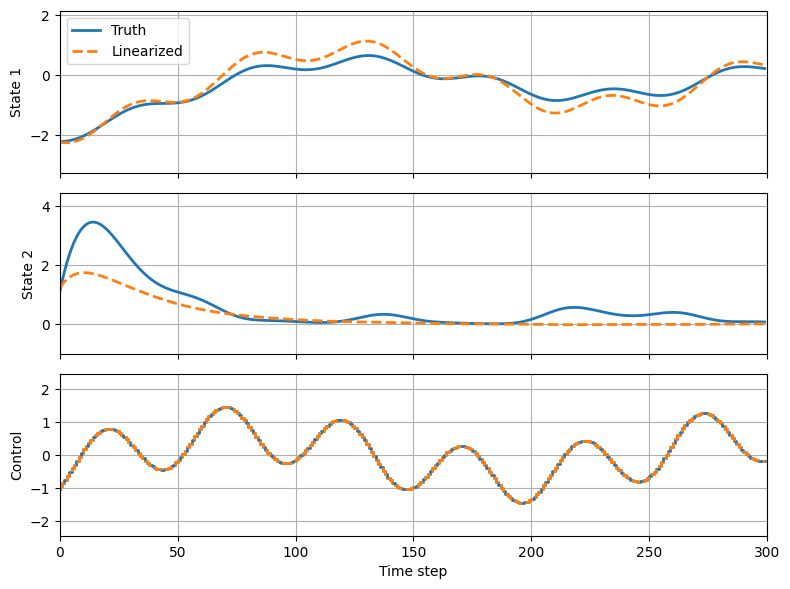

In [35]:
# Sample one random trajectory:
N = 300
t_grid = np.linspace(0, 10, N)
ts, xs, us, ys = sampler.sample(t_grid, batch=1)

# Extract data:
x_true = xs[0]
t_data = ts[0]
u_data = us[0]
x0 = x_true[0]
n_tsteps = len(x_true) - 1

# Linearized prediction:
x_linear, _ = prop_dyn_latent(model, A, B, C, x0, u_seq=u_data)

# Plot comparison:
plot_traj(np.stack([x_true.T, x_linear[1:].T], axis=-1), u_data, N, lab=["Truth", "Linearized"], line=["-", "--"])

Then, we can perform the usual controllability analysis:

In [22]:
# Check for stability:
n_tsteps = 500
eigs = np.linalg.eigvals(A)

# Calculate Controllability matrix & Gramian for latent space:
Ctrl, W = controllability(A, B, n_tsteps)
rank_Wc = np.linalg.matrix_rank(W)

# Check real-space controllability using C-augmented controllability matrix:
Ctrl_obs = rs_controllability(A, B, C, n_tsteps)
rank_obs = np.linalg.matrix_rank(Ctrl_obs)

# Print results for stability:
if np.all(abs(eigs) < 1):
    print("SYSTEM IS STABLE")
else:
    print("SYSTEM IS UNSTABLE")

# Print results for controllability:
if rank_Wc == A.shape[0] and rank_obs == C.shape[0]:
    print(f"LATENT AND REAL SPACE ARE CONTROLLABLE")
elif rank_Wc == A.shape[0] and rank_obs != C.shape[0]:
    print(f"LATENT SPACE IS CONTROLLABLE, BUT REAL SPACE IS NOT CONTROLLABLE")
else:
    print(f"NEITHER THE REAL OR LATENT SPACE ARE CONTROLLABLE")

SYSTEM IS UNSTABLE
LATENT AND REAL SPACE ARE CONTROLLABLE
